In [ ]:
! pip install transformers==3

     |████████████████████████████████| 754 kB 5.3 MB/s 
     |████████████████████████████████| 3.0 MB 35.3 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 1.2 MB 33.6 MB/s 


In [ ]:
! apt install psmisc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
psmisc is already the newest version (23.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
! sudo fuser /dev/nvidia*

In [ ]:
! kill -9 62

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=203231ebfb7549d22cdaa1c1bdbea824203a4c77158a4be6cfb0b83181f7d5e2
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free:" + humanize.naturalsize(psutil.virtual_memory().available)," |     Proc size:" + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free:12.7 GB  |     Proc size:118.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

df = pd.read_excel (r'/content/gdrive/My Drive/manually_annotated_data/imrad_labeling_300_reconciled.xlsx')
print (df)

          PMID  ...                                           SENTENCE
0     29958222  ...  The aepEXplus monitoring system, which uses mi...
1     29958222  ...  Seventy-five patients, 1-18 years of age (stra...
2     29958222  ...  The aepEX and the bispectral index (BIS) were ...
3     29958222  ...  The ability of the aepEX to detect different l...
4     29958222  ...  As a secondary outcome parameter, the relation...
...        ...  ...                                                ...
3290  29957866  ...  The risk of MSP was greater for AD, female, Ar...
3291  29957866  ...  Evidence suggests posttraumatic headache, occu...
3292  29957866  ...  Nurses must recognize the consequences militar...
3293  29957866  ...  Nurses have an opportunity to positively impac...
3294  29957866  ...  The findings from this review underscore consi...

[3295 rows x 8 columns]


In [ ]:
df

,PMID,Unnamed: 1,SENTID,Unnamed: 3,STRUCTURED ABSTRACT LABEL,NORMALIZED LABEL/PREDICTION,GOLD,SENTENCE
0,29958222,ab,1,29958222,BACKGROUND,BACKGROUND,OBJECTIVE,"The aepEXplus monitoring system, which uses mi..."
1,29958222,ab,2,29958222,METHODS,METHODS,METHODS,"Seventy-five patients, 1-18 years of age (stra..."
2,29958222,ab,3,29958222,METHODS,METHODS,METHODS,The aepEX and the bispectral index (BIS) were ...
3,29958222,ab,4,29958222,METHODS,METHODS,METHODS,The ability of the aepEX to detect different l...
4,29958222,ab,5,29958222,METHODS,METHODS,METHODS,"As a secondary outcome parameter, the relation..."
...,...,...,...,...,...,...,...,...
3290,29957866,ab,10,29957866,RESULTS,RESULTS,RESULTS,"The risk of MSP was greater for AD, female, Ar..."
3291,29957866,ab,11,29957866,RESULTS,RESULTS,RESULTS,"Evidence suggests posttraumatic headache, occu..."
3292,29957866,ab,12,29957866,IMPLICATIONS,CONCLUSIONS,CONCLUSIONS,Nurses must recognize the consequences militar...
3293,29957866,ab,13,29957866,IMPLICATIONS,CONCLUSIONS,CONCLUSIONS,Nurses have an opportunity to positively impac...


In [ ]:
saved_string = ""
pmid = ""
for k, i in df.iterrows():
  if pmid != i["PMID"] and pmid != "":
    saved_string += "\n"
  saved_string = saved_string + i["SENTENCE"].lower() + "\t" + i["GOLD"].upper() + "\n"


In [ ]:
saved_string

'the aepexplus monitoring system, which uses mid-latency auditory evoked potentials to measure depth of hypnosis, was evaluated in pediatric patients receiving desflurane-remifentanil anesthesia.\tOBJECTIVE\nseventy-five patients, 1-18 years of age (stratified for age; 1-3, 3-6, 6-18 years, for subgroup analyses), were included in this prospective observational study.\tMETHODS\nthe aepex and the bispectral index (bis) were recorded simultaneously, the latter serving as a reference.\tMETHODS\nthe ability of the aepex to detect different levels of consciousness, defined according to the university of michigan sedation scale, investigated using prediction probability (pk), and receiver operating characteristic (roc) analysis, served as the primary outcome parameter.\tMETHODS\nas a secondary outcome parameter, the relationship between end-tidal desflurane and the aepex and bis values were calculated by fitting in a nonlinear regression model.\tMETHODS\nthe pk values for the aepex and the b

In [ ]:
df["GOLD"].value_counts()

RESULTS        1154
METHODS         785
BACKGROUND      538
CONCLUSIONS     520
OBJECTIVE       282
NONE             16
Name: GOLD, dtype: int64

In [ ]:
unstructured = set()

for key, i in df.iterrows():
  if str(i["STRUCTURED ABSTRACT LABEL"]) == "nan":
    unstructured.add(i["PMID"])

for key, i in df.iterrows():
  if str(i["STRUCTURED ABSTRACT LABEL"]) != "nan" and i["PMID"] in unstructured:
    unstructured.remove(i["PMID"])

In [ ]:
len(unstructured)

100

In [ ]:
import re

flag = 0
pubmedid = []
abstracts = []
for key, i in df.iterrows():
  if i.PMID != flag:
    if flag != 0:
      abstracts.append(new_abstract)
    new_abstract = []
    pubmedid.append(i.PMID)
    flag = i.PMID
  SENTENCE = re.sub("\d+", "@", i.SENTENCE)
  new_abstract.append(i.GOLD + "\t" + SENTENCE)

abstracts.append(new_abstract)


In [ ]:
total = 0
for i in abstracts:
  total = total + len(i)

In [ ]:
pmid_train = pubmedid[:200]
pmid_test = pubmedid[200:]
abstracts_train = abstracts[:200]
abstracts_test = abstracts[200:]

In [ ]:
total = 0
for i in abstracts_train:
  total = total + len(i)

In [ ]:
total

2198

In [ ]:
pmid_train_set = set(pmid_train)
pmid_test_set = set(pmid_test)

In [ ]:
import random
pmid_unstructured_test_set = random.sample(unstructured, 33)

In [ ]:
pmid_unstructured_train_set = unstructured - set(pmid_unstructured_test_set)

In [ ]:
pmid_structured_test_set = random.sample((set(pubmedid) - unstructured), 67)

In [ ]:
pmid_structured_train_set = set(pubmedid) - unstructured - set(pmid_structured_test_set)

In [ ]:
len(pmid_structured_train_set)

133

In [ ]:
import re

flag = 0
pubmedid = []
abstracts_structured_train = []
abstracts_structured_test = []
abstracts_unstructured_train = []
abstracts_unstructured_test = []

for key, i in df.iterrows():
  if i.PMID != flag:
    if flag != 0:
      if flag in list(pmid_structured_train_set):
        abstracts_structured_train.append(new_abstract)
      elif flag in list(pmid_structured_test_set):
        abstracts_structured_test.append(new_abstract)
      elif flag in list(pmid_unstructured_train_set):
        abstracts_unstructured_train.append(new_abstract)
      elif flag in list(pmid_unstructured_test_set):
        abstracts_unstructured_test.append(new_abstract)        
    new_abstract = []
    pubmedid.append(i.PMID)
    flag = i.PMID
  if str(i.GOLD) != "NONE":
    SENTENCE = re.sub("\d+", "@", i.SENTENCE)
    new_abstract.append(i.GOLD + "\t" + SENTENCE)

if flag in list(pmid_structured_train_set):
  abstracts_structured_train.append(new_abstract)
elif flag in list(pmid_structured_test_set):
  abstracts_structured_test.append(new_abstract)
elif flag in list(pmid_unstructured_train_set):
  abstracts_unstructured_train.append(new_abstract)
elif flag in list(pmid_unstructured_test_set):
  abstracts_unstructured_test.append(new_abstract)   

In [ ]:
saved_string_abs_stu_train = ""
saved_string_abs_stu_test = ""
saved_string_abs_unstu_train = ""
saved_string_abs_unstu_test = ""
for i in abstracts_structured_train:
  for j in i:
    k = j.split("\t")
    saved_string_abs_stu_train += k[1] +"\t" + k[0] + "\n"
  saved_string_abs_stu_train += "\n"
for i in abstracts_structured_test:
  for j in i:
    k = j.split("\t")
    saved_string_abs_stu_test += k[1] +"\t" + k[0] + "\n"
  saved_string_abs_stu_test += "\n"
for i in abstracts_unstructured_train:
  for j in i:
    k = j.split("\t")
    saved_string_abs_unstu_train += k[1] +"\t" + k[0] + "\n"
  saved_string_abs_unstu_train += "\n"
for i in abstracts_unstructured_test:
  for j in i:
    k = j.split("\t")
    saved_string_abs_unstu_test += k[1] +"\t" + k[0] + "\n"
  saved_string_abs_unstu_test += "\n"



In [ ]:
text_file = open("/content/gdrive/My Drive/imrd_data_pubmed/manual_stu_train.txt", "w")
n = text_file.write(saved_string_abs_stu_train)
text_file.close()
text_file = open("/content/gdrive/My Drive/imrd_data_pubmed/manual_stu_test.txt", "w")
n = text_file.write(saved_string_abs_stu_test)
text_file.close()
text_file = open("/content/gdrive/My Drive/imrd_data_pubmed/manual_unstu_train.txt", "w")
n = text_file.write(saved_string_abs_unstu_train)
text_file.close()
text_file = open("/content/gdrive/My Drive/imrd_data_pubmed/manual_unstu_test.txt", "w")
n = text_file.write(saved_string_abs_unstu_test)
text_file.close()

In [ ]:
import re

flag = 0
abstracts_structured_test_original = []

for key, i in df.iterrows():
  if i.PMID != flag:
    if flag != 0:
      if flag in list(pmid_structured_test_set):
        abstracts_structured_test_original.append(new_abstract)     
    new_abstract = []
    pubmedid.append(i.PMID)
    flag = i.PMID
  if str(i.GOLD) != "NONE" :
    SENTENCE = re.sub("\d+", "@", i.SENTENCE)
    if str(i["NORMALIZED LABEL/PREDICTION"]) != "nan":
      new_abstract.append(str(i["NORMALIZED LABEL/PREDICTION"]) + "\t" + SENTENCE)
    else:
      new_abstract.append(str(i["GOLD"]) + "\t" + SENTENCE)


if flag in list(pmid_structured_test_set):
  abstracts_structured_test_original.append(new_abstract)   

In [ ]:
len(abstracts_structured_train)

133

In [ ]:
total = 0
for i in abstracts_structured_train:
  total = total + len(i)

In [ ]:
print(total)

1610


In [ ]:
ls_train_structured = ""
for i in range(len(list(pmid_structured_train_set))):
  ls_train_structured = ls_train_structured + "###" + str(pmid_train[i]) + "\n"
  for j in abstracts_structured_train[i]:
    ls_train_structured = ls_train_structured + j + "\n"
  ls_train_structured = ls_train_structured + "\n"

ls_train_unstructured = ""
for i in range(len(list(pmid_unstructured_train_set))):
  ls_train_unstructured = ls_train_unstructured + "###" + str(pmid_train[i]) + "\n"
  for j in abstracts_unstructured_train[i]:
    ls_train_unstructured = ls_train_unstructured + j + "\n"
  ls_train_unstructured = ls_train_unstructured + "\n"

ls_test_structured = ""
for i in range(len(list(pmid_structured_test_set))):
  ls_test_structured = ls_test_structured + "###" + str(pmid_test[i]) + "\n"
  for j in abstracts_structured_test[i]:
    ls_test_structured = ls_test_structured + j + "\n"
  ls_test_structured = ls_test_structured + "\n"

ls_test_unstructured = ""
for i in range(len(list(pmid_unstructured_test_set))):
  ls_test_unstructured = ls_test_unstructured + "###" + str(pmid_test[i]) + "\n"
  for j in abstracts_unstructured_test[i]:
    ls_test_unstructured = ls_test_unstructured + j + "\n"
  ls_test_unstructured = ls_test_unstructured + "\n"

ls_test_structured_original = ""
for i in range(len(list(pmid_structured_test_set))):
  ls_test_structured_original = ls_test_structured_original + "###" + str(pmid_test[i]) + "\n"
  for j in abstracts_structured_test_original[i]:
    ls_test_structured_original = ls_test_structured_original + j + "\n"
  ls_test_structured_original = ls_test_structured_original + "\n"

In [ ]:
file1 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_structured_train.txt","w")
file1.write(ls_train_structured)
file1.close()

file2 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_unstructured_train.txt","w")
file2.write(ls_train_unstructured)
file2.close()

file3 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_structured_test.txt","w")
file3.write(ls_test_structured)
file3.close()

file4 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_unstructured_test.txt","w")
file4.write(ls_test_unstructured)
file4.close()

file5 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_train.txt","w")
file5.write(ls_train_structured + ls_train_unstructured)
file5.close()

file6 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_test.txt","w")
file6.write(ls_test_structured + ls_test_unstructured)
file6.close()

file7 = open("/content/gdrive/My Drive/manually_annotated_data/manually_annotated_structured_test_original.txt","w")
file7.write(ls_test_structured_original)
file7.close()


In [ ]:
ls_test

NameError: ignored

In [ ]:

df[:2716].GOLD.value_counts()

In [ ]:
def convert_label_2(label):
    
    if label == "BACKGROUND":
        return np.array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
    if label == "OBJECTIVE":
        return np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
    if label == "METHODS":
        return np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
    if label == "RESULTS":
        return np.array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0])
    if label == "CONCLUSIONS":
        return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
    return None

In [ ]:
df["labels"] = df["GOLD"].apply(convert_label_2)

In [ ]:
df = df[~df['labels'].isnull()]

In [ ]:
df

,PMID,Unnamed: 1,SENTID,Unnamed: 3,STRUCTURED ABSTRACT LABEL,NORMALIZED LABEL/PREDICTION,GOLD,SENTENCE,labels
0,29958222,ab,1,29958222,BACKGROUND,BACKGROUND,OBJECTIVE,"The aepEXplus monitoring system, which uses mi...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,29958222,ab,2,29958222,METHODS,METHODS,METHODS,"Seventy-five patients, 1-18 years of age (stra...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2,29958222,ab,3,29958222,METHODS,METHODS,METHODS,The aepEX and the bispectral index (BIS) were ...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,29958222,ab,4,29958222,METHODS,METHODS,METHODS,The ability of the aepEX to detect different l...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,29958222,ab,5,29958222,METHODS,METHODS,METHODS,"As a secondary outcome parameter, the relation...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
3290,29957866,ab,10,29957866,RESULTS,RESULTS,RESULTS,"The risk of MSP was greater for AD, female, Ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3291,29957866,ab,11,29957866,RESULTS,RESULTS,RESULTS,"Evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3292,29957866,ab,12,29957866,IMPLICATIONS,CONCLUSIONS,CONCLUSIONS,Nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3293,29957866,ab,13,29957866,IMPLICATIONS,CONCLUSIONS,CONCLUSIONS,Nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
df["SENTENCE"] = df["SENTENCE"].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Text = df["SENTENCE"].tolist()

In [ ]:
labels = df["labels"].tolist()

In [ ]:
len(labels)

3279

In [ ]:
label_dict = {"BACKGROUND": 1, "OBJECTIVE": 2, "METHODS": 3, "RESULTS": 4, "CONCLUSIONS": 5}


In [ ]:
df_train = df[:2716]
df_test = df[2716:]

In [ ]:
df_test

,PMID,Unnamed: 1,SENTID,Unnamed: 3,STRUCTURED ABSTRACT LABEL,NORMALIZED LABEL/PREDICTION,GOLD,SENTENCE,labels
2730,29958266,ab,5,29958266,METHODS,METHODS,METHODS,"we extracted data from the systematic reviews,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2731,29958266,ab,6,29958266,CONCLUSIONS,CONCLUSIONS,RESULTS,we identified twelve systematic reviews includ...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2732,29958266,ab,7,29958266,CONCLUSIONS,CONCLUSIONS,CONCLUSIONS,we concluded that intra-articular injection of...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2733,29958266,ab,8,29958266,CONCLUSIONS,CONCLUSIONS,CONCLUSIONS,"as for the adverse effects, if they exist, the...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2734,29909568,ab,1,29909568,INTRODUCTION,BACKGROUND,BACKGROUND,the association between the checkpoint kinase ...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
3290,29957866,ab,10,29957866,RESULTS,RESULTS,RESULTS,"the risk of msp was greater for ad, female, ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3291,29957866,ab,11,29957866,RESULTS,RESULTS,RESULTS,"evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3292,29957866,ab,12,29957866,IMPLICATIONS,CONCLUSIONS,CONCLUSIONS,nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3293,29957866,ab,13,29957866,IMPLICATIONS,CONCLUSIONS,CONCLUSIONS,nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
train_dataset = pd.DataFrame(list(zip(Text, labels)),
               columns =['text', 'labels'])

In [ ]:
train_dataset

,text,labels
0,"the aepexplus monitoring system, which uses mi...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,"seventy-five patients, 1-18 years of age (stra...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2,the aepex and the bispectral index (bis) were ...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,the ability of the aepex to detect different l...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,"as a secondary outcome parameter, the relation...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...
3274,"the risk of msp was greater for ad, female, ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3275,"evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3276,nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3277,nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
df_train = train_dataset[:2716]
df_test = train_dataset[2716:]
test_text = df_test["text"].to_list()
test_label = df_test["labels"].to_list()

In [ ]:
df_test = pd.DataFrame(list(zip(test_text, test_label)),
               columns =['text', 'labels'])


In [ ]:
df_test

,text,labels
0,"we extracted data from the systematic reviews,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,we identified twelve systematic reviews includ...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,we concluded that intra-articular injection of...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,"as for the adverse effects, if they exist, the...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,the association between the checkpoint kinase ...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
558,"the risk of msp was greater for ad, female, ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
559,"evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
560,nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
561,nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1', do_lower_case=True)

In [ ]:

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len, col='text'):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.train_col = dataframe[col]
        print(self.data.labels)
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.train_col)

    def __getitem__(self, index):
        train_col = str(self.train_col[index])
        train_col = " ".join(train_col.split())

        inputs = self.tokenizer.encode_plus(
            train_col,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float16)
        }

In [ ]:
training_set = CustomDataset(df_train, tokenizer, MAX_LEN, col='text')
validation_set = CustomDataset(df_test, tokenizer, MAX_LEN, col='text')
validation_set_ = CustomDataset(train_dataset, tokenizer, MAX_LEN, col='text')


0       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
1       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
2       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
3       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
4       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
                     ...              
2711    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
2712    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
2713    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
2714    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
2715    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Name: labels, Length: 2716, dtype: object
0      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
1      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
2      [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
3      [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
4      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
                    ...              
558    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
559    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
560    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
561    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
562    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Name: labels, Length: 563, dtype: object
0       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
1       [0.0, 0.0, 0.0, 1.0, 0.

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params_ = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

In [ ]:
training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)
validation_loader_ = DataLoader(validation_set_, **test_params_)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    # return model, optimizer, checkpoint['epoch'], valid_loss_min.item()
    return model, optimizer
    

In [ ]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
val_targets=[]
val_outputs=[] 

In [ ]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = int(train_loss + ((1 / (batch_idx + 1)) * (loss- train_loss)))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    # model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = int(valid_loss + ((1 / (batch_idx + 1)) * (loss - valid_loss)))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/bert_imrd_models_manually_annotated/current_checkpoint.pt'
best_model = '/content/gdrive/MyDrive/bert_imrd_models_manually_annotated//best_model.pt'


In [ ]:
trained_model = train_model(1, 4, np.Inf, training_loader, validation_loader, model, optimizer,checkpoint_path,best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000000 	Average Validation Loss: 0.000000
Validation loss decreased (inf --> 0.000000).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000000 	Average Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [ ]:
class PrepForPredictionDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['text']
        #self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
           # 'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
df_train

,text,labels
0,"the aepexplus monitoring system, which uses mi...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,"seventy-five patients, 1-18 years of age (stra...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2,the aepex and the bispectral index (bis) were ...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,the ability of the aepex to detect different l...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,"as a secondary outcome parameter, the relation...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...
2711,this case confirms that the length of calcanea...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2712,despite varied non-surgical alternatives for t...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2713,"in the last decade, the use of intra-articular...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2714,"however, there is controversy about its clinic...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
df_test

,text,labels
0,"we extracted data from the systematic reviews,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,we identified twelve systematic reviews includ...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,we concluded that intra-articular injection of...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,"as for the adverse effects, if they exist, the...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,the association between the checkpoint kinase ...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
558,"the risk of msp was greater for ad, female, ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
559,"evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
560,nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
561,nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
testing_set = PrepForPredictionDataset(df_test, tokenizer, MAX_LEN)


In [ ]:
testing_loader = DataLoader(testing_set, **test_params)


In [ ]:
def do_prediction(loader):
    trained_model.eval()
   
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            #fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [ ]:
pred_outputs = do_prediction(testing_loader)

NameError: ignored

In [ ]:
len(pred_outputs)

479

In [ ]:
val_pred = (np.array(pred_outputs))
val_pred = np.argmax(val_pred, axis=1)

In [ ]:
val_pred

array([4, 4, 5, 3, 1, 5, 5, 1, 4, 2, 3, 3, 4, 4, 5, 1, 1, 1, 5, 2, 3, 3,
       3, 3, 5, 4, 5, 5, 5, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 2, 4, 3, 4, 5,
       5, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 1, 1, 2, 3, 3, 4, 4, 4, 5, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 5, 1, 1, 1, 2, 2, 4, 5,
       1, 1, 1, 2, 4, 4, 4, 5, 1, 1, 1, 5, 1, 3, 4, 4, 4, 4, 4, 4, 5, 5,
       2, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 4, 1, 1, 2, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 5, 1, 3, 4, 4, 4, 4, 1, 1, 1, 2, 2, 3, 3, 3, 4,
       4, 5, 1, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 1, 1, 1, 5, 1, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 2, 1, 2, 3, 3, 3, 4, 4, 4, 3, 3,
       5, 2, 4, 4, 4, 4, 5, 5, 2, 3, 3, 4, 3, 3, 5, 1, 2, 3, 3, 3, 4, 4,
       4, 5, 2, 2, 3, 3, 3, 3, 1, 3, 5, 2, 3, 5, 1, 3, 4, 4, 5, 4, 1, 5,
       1, 5, 1, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 1, 5, 4, 4, 4, 4, 1,
       5, 5, 4, 4, 4, 1, 1, 4, 3, 3, 3, 3, 4, 4, 1, 5, 5, 1, 1, 1, 3, 3,
       3, 4, 4, 4, 4, 4, 1, 4, 2, 3, 3, 2, 4, 4, 2,

In [ ]:
val_target = np.argmax(labels, axis=1)

In [ ]:
val_target = val_target[2800:]

In [ ]:
accuracy = metrics.accuracy_score(val_target, val_pred)
f1_score_micro = metrics.f1_score(val_target, val_pred, average='micro')
f1_score_macro = metrics.f1_score(val_target, val_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}") #计算所有类的recall 和 precision，由公式f1=2*(r*p)/(r+p)
print(f"F1 Score (Macro) = {f1_score_macro}") #所有类的f1值的和除以类别数，eg:(f1+f2+f3)/3

Accuracy Score = 0.7891440501043842
F1 Score (Micro) = 0.7891440501043842
F1 Score (Macro) = 0.7931282524562374


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
cm_labels = ["B", "O", "M", "R", "C"]
    
cm = mcm(val_target, val_pred)#混淆矩阵

In [ ]:
print(classification_report(val_target, val_pred,target_names=cm_labels))

              precision    recall  f1-score   support

           B       0.82      0.72      0.76        88
           O       0.81      0.87      0.84        39
           M       0.87      0.79      0.83       120
           R       0.78      0.83      0.81       152
           C       0.58      0.65      0.61        80

    accuracy                           0.77       479
   macro avg       0.77      0.77      0.77       479
weighted avg       0.78      0.77      0.77       479



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

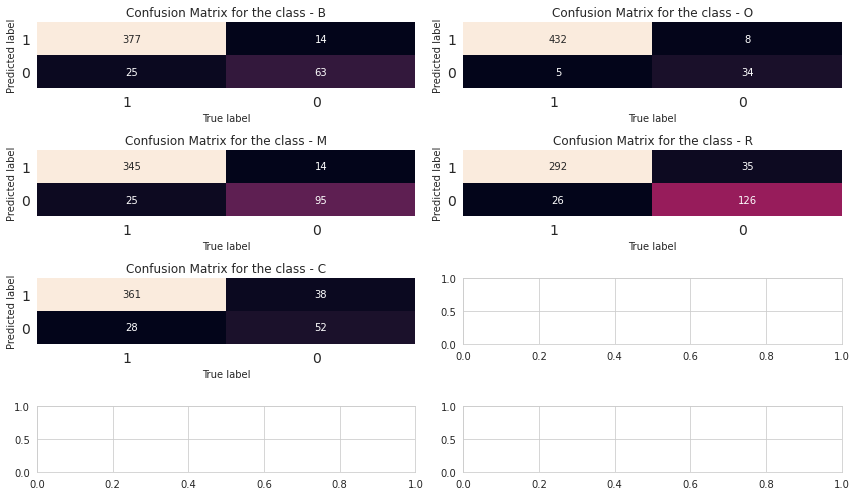

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(4, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
fig.tight_layout()
plt.show()

In [ ]:
df_test

,text,labels
0,"physical, chemical, ergonomic and radiation ri...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1,the general occupational risk factor score was...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,nurses working night duty were confronted with...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,reported occupational health problems by nurse...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,nurses experience different occupational risks.,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...
474,"the risk of msp was greater for ad, female, ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
475,"evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
476,nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
477,nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
val_target = np.argmax(labels, axis=1)
val_target = val_target[2800:]

In [ ]:
testing_set = PrepForPredictionDataset(df_test, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **test_params)
pred_outputs = do_prediction(testing_loader)


In [ ]:
val_pred = (np.array(pred_outputs))
val_pred = np.argmax(val_pred, axis=1)

In [ ]:
accuracy = metrics.accuracy_score(val_target, val_pred)
f1_score_micro = metrics.f1_score(val_target, val_pred, average='micro')
f1_score_macro = metrics.f1_score(val_target, val_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}") 
print(f"F1 Score (Macro) = {f1_score_macro}") 

Accuracy Score = 0.7891440501043842
F1 Score (Micro) = 0.7891440501043842
F1 Score (Macro) = 0.7931282524562374


In [ ]:
len(val_pred)

479

In [ ]:
cm = mcm(val_target, val_pred)
print(classification_report(val_target, val_pred,target_names=cm_labels))

              precision    recall  f1-score   support

           B       0.81      0.83      0.82        88
           O       0.83      0.87      0.85        39
           M       0.84      0.79      0.82       120
           R       0.78      0.79      0.78       152
           C       0.69      0.70      0.70        80

    accuracy                           0.79       479
   macro avg       0.79      0.80      0.79       479
weighted avg       0.79      0.79      0.79       479



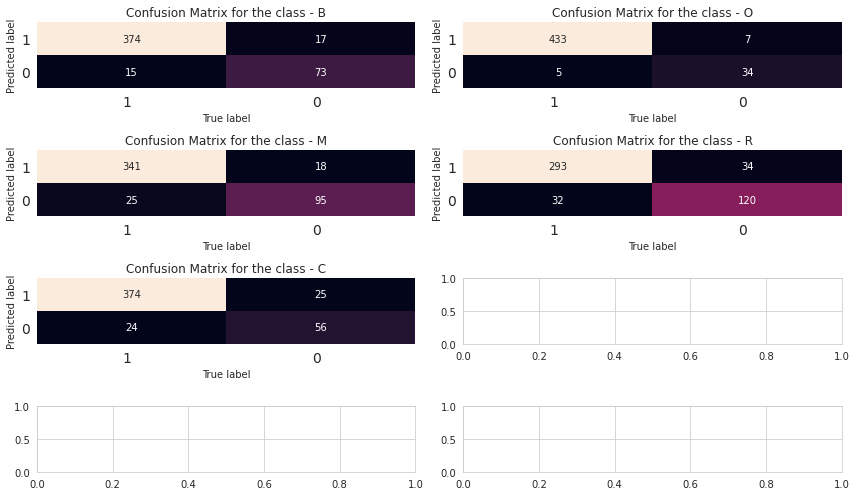

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(4, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
fig.tight_layout()
plt.show()

In [ ]:
cm

array([[[369,  22],
        [ 20,  68]],

       [[433,   7],
        [  6,  33]],

       [[341,  18],
        [ 20, 100]],

       [[294,  33],
        [ 27, 125]],

       [[371,  28],
        [ 35,  45]]])

Test on the model trained by the Pubmed 20k

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/bert_imrd_models/current_checkpoint.pt'
best_model = '/content/gdrive/MyDrive/bert_imrd_models/best_model.pt'

In [ ]:
class PrepForPredictionDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['text']
        #self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
           # 'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
def do_prediction(loader):
    trained_model.eval()
   
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            #fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [ ]:
trained_model, optimizer = load_ckp(checkpoint_path, model, optimizer)


In [ ]:
testing_set = PrepForPredictionDataset(df_test, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **test_params)
pred_outputs = do_prediction(testing_loader)


In [ ]:
val_pred = (np.array(pred_outputs))
val_pred = np.argmax(val_pred, axis=1)

In [ ]:
len(val_pred)

563

In [ ]:
val_target = np.argmax(labels, axis=1)

In [ ]:
val_target = np.argmax(labels, axis=1)
val_target = val_target[2716:]

In [ ]:
accuracy = metrics.accuracy_score(val_target, val_pred)
f1_score_micro = metrics.f1_score(val_target, val_pred, average='micro')
f1_score_macro = metrics.f1_score(val_target, val_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}") #计算所有类的recall 和 precision，由公式f1=2*(r*p)/(r+p)
print(f"F1 Score (Macro) = {f1_score_macro}") #所有类的f1值的和除以类别数，eg:(f1+f2+f3)/3

Accuracy Score = 0.7886323268206039
F1 Score (Micro) = 0.7886323268206039
F1 Score (Macro) = 0.7998818623864894


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(val_target, val_pred)

array([[ 81,   2,   1,   1,  14],
       [  1,  43,   3,   0,   0],
       [  0,   6, 117,  16,   4],
       [  2,   1,   5, 123,  50],
       [ 10,   0,   2,   1,  80]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
target_names = ["B","O","M","R", "C"]
print(classification_report(val_target, val_pred, target_names = target_names))

              precision    recall  f1-score   support

           B       0.86      0.82      0.84        99
           O       0.83      0.91      0.87        47
           M       0.91      0.82      0.86       143
           R       0.87      0.68      0.76       181
           C       0.54      0.86      0.66        93

    accuracy                           0.79       563
   macro avg       0.80      0.82      0.80       563
weighted avg       0.82      0.79      0.79       563



In [ ]:
for i in range(len(val_target)):
    if val_target[i] != val_pred[i]:
        print(train_dataset.iloc[i]["text"], 'has been classified as ', val_target[i], 'and should be ', val_pred[i]) 
    #     print(count)
    #     count_ += 1
    # count += 1

the aepex and the bispectral index (bis) were recorded simultaneously, the latter serving as a reference. has been classified as  4 and should be  5
the ability of the aepex to detect different levels of consciousness, defined according to the university of michigan sedation scale, investigated using prediction probability (pk), and receiver operating characteristic (roc) analysis, served as the primary outcome parameter. has been classified as  5 and should be  3
as a secondary outcome parameter, the relationship between end-tidal desflurane and the aepex and bis values were calculated by fitting in a nonlinear regression model. has been classified as  5 and should be  1
the age-corrected end-tidal desflurane concentration associated with an index value of 50 (ec50) was 0.59 minimum alveolar concentration (interquartile range: 0.38-0.85) and 0.58 minimum alveolar concentration (interquartile range: 0.41-0.70) for, respectively, the aepex and bis (p = .69). has been classified as  1 an

In [ ]:
train_dataset

,text,labels
0,"the aepexplus monitoring system, which uses mi...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,"seventy-five patients, 1-18 years of age (stra...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2,the aepex and the bispectral index (bis) were ...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,the ability of the aepex to detect different l...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,"as a secondary outcome parameter, the relation...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...
3274,"the risk of msp was greater for ad, female, ar...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3275,"evidence suggests posttraumatic headache, occu...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3276,nurses must recognize the consequences militar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3277,nurses have an opportunity to positively impac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
